In [297]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

from tqdm import tqdm
import os 

tqdm.pandas()

# my Helper functions

from HelperFunctions import *

import xgboost as xgb 
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import yellowbrick.model_selection as ms

In [299]:
landsat_training_data = pd.read_csv('../Datasets/landsat_features_training.csv')
terra_climate_training_data = pd.read_csv('../Datasets/terraclimate_features_training.csv')
explained_variables = pd.read_csv('../Datasets/water_quality_training_dataset.csv')

joined_explaining_vars = combine_two_datasets(landsat_training_data, terra_climate_training_data)
full_dataset = combine_two_datasets(joined_explaining_vars, explained_variables)

#adicionando caracteristicas temporais cíclicas para o modelo
full_dataset['Sample Date'] = pd.to_datetime(full_dataset['Sample Date'], dayfirst=True)

full_dataset['WeekOfYear'] = full_dataset['Sample Date'].dt.isocalendar().week.astype(int)
##full_dataset['MonthOfYear'] = full_dataset['Sample Date'].dt.month

MAX_CYCLE = 52
##MAX_CYCLE = 12

full_dataset['WOY_sin'] = np.sin(2 * np.pi * full_dataset['WeekOfYear'] / MAX_CYCLE)
full_dataset['WOY_cos'] = np.cos(2 * np.pi * full_dataset['WeekOfYear'] / MAX_CYCLE)
##full_dataset['Month_sin'] = np.sin(2 * np.pi * full_dataset['MonthOfYear'] / MAX_CYCLE)
##full_dataset['Month_cos'] = np.cos(2 * np.pi * full_dataset['MonthOfYear'] / MAX_CYCLE)


target_columns = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']

feature_columns = full_dataset.columns.drop(target_columns + ['Sample Date', 'Latitude', 'Longitude', "WeekOfYear"])
##feature_columns = full_dataset.columns.drop(target_columns + ['Sample Date', 'Latitude', 'Longitude', "MonthOfYear"])

Feature_data = full_dataset[feature_columns]
#Target_data = full_dataset[target_columns]

Target_data = full_dataset[target_columns]


X_train_val, X_test, y_train_val, y_test = train_test_split(Feature_data, Target_data, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15)


X_train

,nir,green,swir16,swir22,NDMI,MNDWI,pet,WOY_sin,WOY_cos
7283,15128.0,10768.0,17617.00,14075.00,-0.076012,-0.241289,182.50000,0.464723,0.885456
8990,9019.0,8995.5,8719.00,8529.00,0.016913,0.015609,219.60000,-0.935016,0.354605
7278,13889.0,9235.0,11220.50,8944.50,0.106275,-0.097064,210.00000,0.464723,0.885456
3267,10866.0,9366.0,8950.50,8179.00,0.096662,0.022684,196.00000,0.239316,0.970942
3242,15975.5,10120.0,16067.50,12355.00,-0.002871,-0.227112,78.30000,0.239316,0.970942
...,...,...,...,...,...,...,...,...,...
2964,14183.0,9801.0,13704.25,11265.25,0.021549,-0.167901,242.50000,-0.822984,0.568065
2690,8372.5,10982.0,7718.00,7656.00,0.040676,0.174545,242.50000,-0.935016,-0.354605
3383,15480.0,9641.5,12922.00,10536.50,0.090064,-0.145390,177.90001,0.663123,0.748511
7408,14183.0,9801.0,13704.25,11265.25,0.021549,-0.167901,177.10000,0.748511,0.663123


## Learning Curve ( see overfitting )

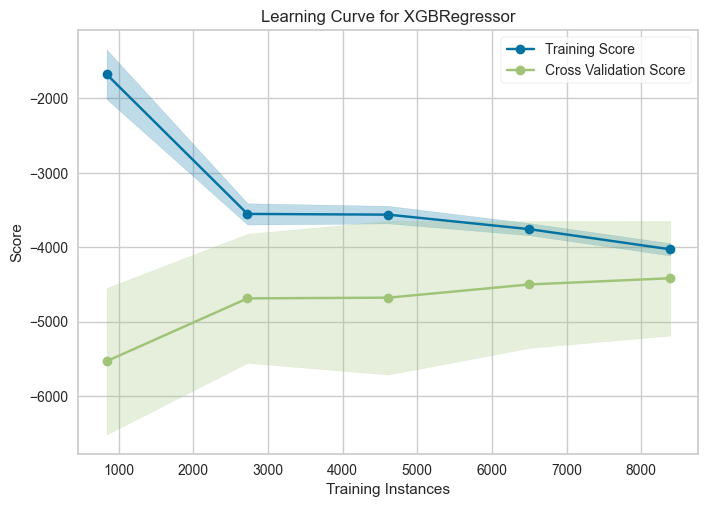

In [9]:
_ = ms.learning_curve(boost_predicter, Feature_data, Target_data, scoring='neg_mean_squared_error', cv=10)

## Feature Importance

In [300]:
dart_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                            booster='dart',
                            learning_rate = 0.05, # bom
                            max_depth = 4, # bom, muda comforme adicionar dados 
                            n_estimators = 110, # bom, muda conforme adicionar dados
                            subsample = 0.6,
                            colsample_bytree = 0.8,
                            min_child_weight=2.0, ## fixado assim, bom
                            gamma=1.0,  ## fixado assim, bom
                            verbosity = 1,
                            rate_drop = 0.25, # bom : 0.25
                            skip_drop = 0.5 # bom : 0.5
)

# parametros treino:

dart_xgb.fit(Feature_data, Target_data,
            eval_set=[(X_val, y_val)])

[0]	validation_0-rmse:209.81104
[1]	validation_0-rmse:207.59577
[2]	validation_0-rmse:206.82821
[3]	validation_0-rmse:206.21955
[4]	validation_0-rmse:205.57286
[5]	validation_0-rmse:203.63332
[6]	validation_0-rmse:203.42210
[7]	validation_0-rmse:201.76583
[8]	validation_0-rmse:201.59942
[9]	validation_0-rmse:201.29693
[10]	validation_0-rmse:200.94373
[11]	validation_0-rmse:200.81230
[12]	validation_0-rmse:199.35921
[13]	validation_0-rmse:199.15625
[14]	validation_0-rmse:199.01403
[15]	validation_0-rmse:197.68364
[16]	validation_0-rmse:197.57227
[17]	validation_0-rmse:197.45765
[18]	validation_0-rmse:197.41559
[19]	validation_0-rmse:196.25464
[20]	validation_0-rmse:196.21896
[21]	validation_0-rmse:195.03812
[22]	validation_0-rmse:194.93763
[23]	validation_0-rmse:193.93679
[24]	validation_0-rmse:192.85012
[25]	validation_0-rmse:192.79227
[26]	validation_0-rmse:191.78127
[27]	validation_0-rmse:191.73860
[28]	validation_0-rmse:190.68172
[29]	validation_0-rmse:190.63761
[30]	validation_0-rm

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,'dart'
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabete

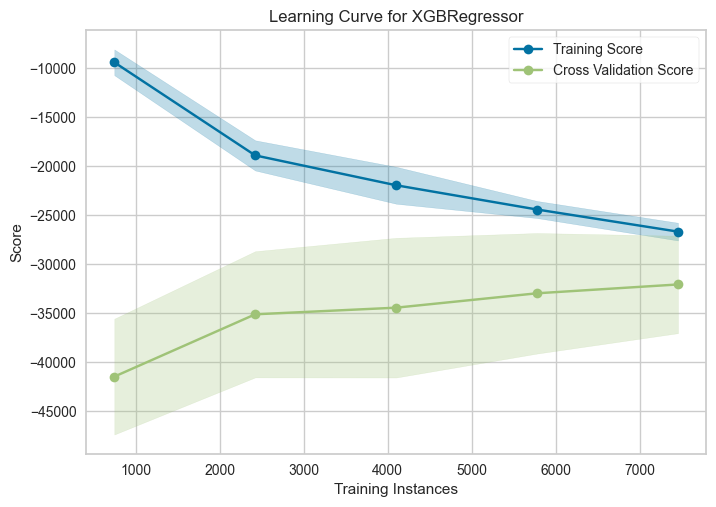

In [287]:
_ = ms.learning_curve(dart_xgb, Feature_data, Target_data, scoring='neg_mean_squared_error', cv=5)

<Axes: >

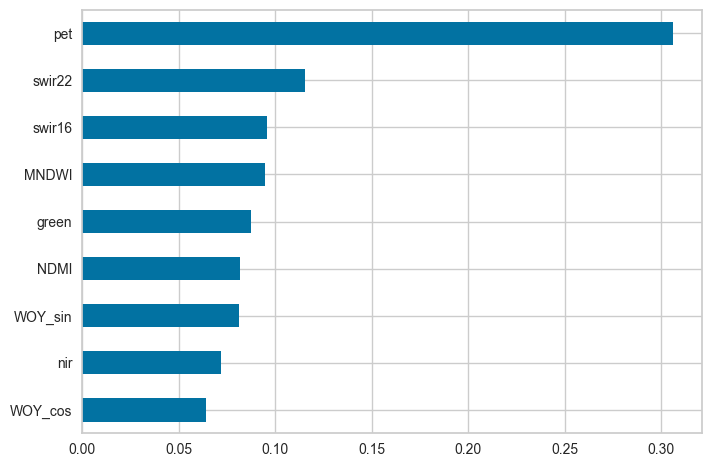

In [301]:
(pd.Series(dart_xgb.feature_importances_, index = X_train.columns).sort_values().plot.barh())

In [302]:
evaluate_model(dart_xgb.predict(X_train), y_train, "train evaluation")
evaluate_model(dart_xgb.predict(X_test), y_test, "test evaluation")
evaluate_model(dart_xgb.predict(X_val), y_val, "validation evaluation")


train evaluation Evaluation:
R²: 0.320
RMSE: 164.039

test evaluation Evaluation:
R²: 0.337
RMSE: 163.753

validation evaluation Evaluation:
R²: 0.297
RMSE: 172.441


(array([[142.40913 , 544.8293  ,  53.60057 ],
        [130.05795 , 541.5352  ,  53.034782],
        [ 92.19491 , 269.81876 ,  17.433428],
        ...,
        [ 68.02586 , 241.78256 ,  24.24238 ],
        [121.90024 , 446.10004 ,  51.882504],
        [ 98.295654, 386.06726 ,  31.975729]], dtype=float32),
 0.29663947224617004,
 np.float64(172.44115277936123))

## Submission

In [305]:
submission_landsat_data = pd.read_csv("../Datasets/landsat_features_validation.csv")
submission_terra_climate_data = pd.read_csv("../Datasets/terraclimate_features_validation.csv")
all_submission_data = combine_two_datasets(submission_landsat_data, submission_terra_climate_data)

all_submission_data['Sample Date'] = pd.to_datetime(all_submission_data['Sample Date'], dayfirst=True)
all_submission_data['WeekOfYear'] = all_submission_data['Sample Date'].dt.isocalendar().week.astype(int)
MAX_CYCLE = 52
all_submission_data['WOY_sin'] = np.sin(2 * np.pi * all_submission_data['WeekOfYear'] / MAX_CYCLE)
all_submission_data['WOY_cos'] = np.cos(2 * np.pi * all_submission_data['WeekOfYear'] / MAX_CYCLE)


In [306]:
X_pred_input_features_columns = all_submission_data.columns.drop(['Latitude', 'Longitude', 'Sample Date', 'WeekOfYear'])
X_pred_input_features = all_submission_data[X_pred_input_features_columns]

y_submission_pred = dart_xgb.predict(X_pred_input_features)
y_submission_pred

array([[110.263374, 392.35657 ,  28.145012],
       [134.91415 , 577.76624 ,  57.595276],
       [ 82.9401  , 522.6502  ,  33.31946 ],
       [ 78.28153 , 235.07384 ,  23.816973],
       [ 97.563255, 304.17368 ,  28.02286 ],
       [150.28433 , 587.5648  ,  38.332077],
       [102.88344 , 272.64496 ,  23.1316  ],
       [ 91.22997 , 335.2683  ,  24.814138],
       [106.01787 , 344.60358 ,  25.274664],
       [ 97.79727 , 381.4204  ,  31.926638],
       [ 57.780727, 352.43723 ,  30.746601],
       [ 76.47249 , 414.50272 ,  34.779194],
       [ 67.674934, 186.2824  ,  17.976461],
       [105.348465, 350.29935 ,  29.061932],
       [ 80.5569  , 241.81546 ,  20.94174 ],
       [130.2754  , 584.9824  ,  49.23177 ],
       [ 67.1263  , 427.59903 ,  29.278383],
       [137.04465 , 654.0742  ,  48.409233],
       [112.72359 , 348.97107 ,  23.699352],
       [108.88799 , 352.34198 ,  25.633566],
       [104.92879 , 339.71915 ,  29.257158],
       [ 77.18376 , 245.25883 ,  24.018183],
       [13

In [307]:
predicted_values_pd = pd.DataFrame({
    'Total Alkalinity': y_submission_pred[:, 0], 
    'Electrical Conductance': y_submission_pred[:, 1], 
    'Dissolved Reactive Phosphorus': y_submission_pred[:, 2]
})

predicted_pd = pd.DataFrame({
    'Latitude': all_submission_data['Latitude'].values,
    'Longitude': all_submission_data['Longitude'].values,
    'Sample Date': all_submission_data['Sample Date'].values,
})
predicted_pd = pd.concat([predicted_pd, predicted_values_pd], axis=1)
predicted_pd


,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus
0,-32.043333,27.822778,2014-09-01,110.263374,392.356567,28.145012
1,-33.329167,26.077500,2015-09-16,134.914154,577.766235,57.595276
2,-32.991639,27.640028,2015-05-07,82.940102,522.650208,33.319462
3,-34.096389,24.439167,2012-02-07,78.281532,235.073837,23.816973
4,-32.000556,28.581667,2014-10-01,97.563255,304.173676,28.022860
...,...,...,...,...,...,...
195,-33.771111,25.386667,2012-12-06,138.090134,518.384888,51.471840
196,-33.185361,27.390750,2014-09-04,74.499962,459.100464,30.073532
197,-32.043333,27.822778,2015-09-28,128.181503,477.855347,38.148975
198,-33.001667,25.161389,2015-01-08,102.104568,467.882019,46.517159


In [308]:
predicted_pd.to_csv("../Results/submission_predictions_boosted.csv", index=False)